# **1. Data Collection & Exploration**

In [11]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install prophet


   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB 2.3 MB/s eta 0:00:06
    --------------------------------------- 0.2/13.3 MB 3.0 MB/s eta 0:00:05
   - -------------------------------------- 0.4/13.3 MB 3.6 MB/s eta 0:00:04
   - -------------------------------------- 0.6/13.3 MB 3.6 MB/s eta 0:00:04
   -- ------------------------------------- 0.8/13.3 MB 3.6 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/13.3 MB 3.5 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/13.3 MB 3.4 MB/s eta 0:00:04
   --- ------------------------------------ 1.1/13.3 MB 3.2 MB/s eta 0:00:04
   --- ------------------------------------ 1.3/13.3 MB 3.2 MB/s eta 0:00:04
   ---- ----------------------------------- 1.5/13.3 MB 3.4 MB/s eta 0:00:04
   ----- ---------------------------------- 1.7/13.3 MB 3.5 MB/s eta 0:00:04
   ----- ---------------------------------- 2.0/13.3 MB 3.7 MB/s eta 0:00:04
   --

Dataset shape: (119390, 32)
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2 

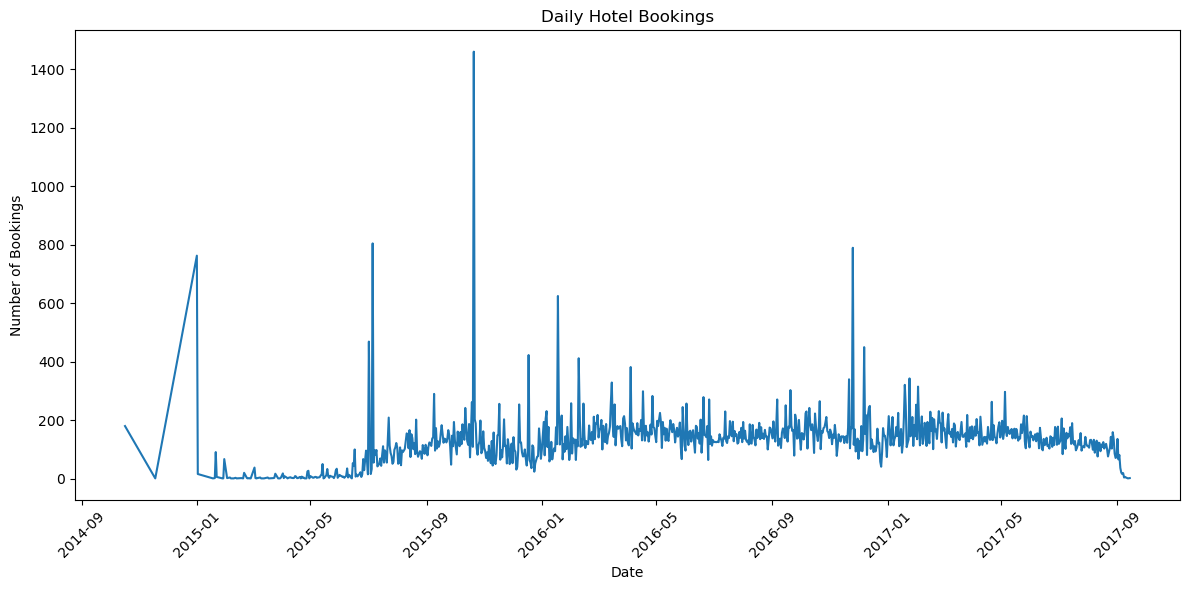

Missing values in time series: 0
ADF Statistic: -2.5457579431037543
p-value: 0.10473404068135961
Critical Values:
	1%: -3.437596348122793
	5%: -2.86473892523805
	10%: -2.5684733191905007
The series is non-stationary and may need differencing


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import streamlit as st
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('hotel_bookings.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df.info())

# Convert reservation_status_date to datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Create a time series of daily bookings
daily_bookings = df.groupby(df['reservation_status_date']).size().reset_index(name='bookings')
daily_bookings = daily_bookings.set_index('reservation_status_date')
daily_bookings = daily_bookings.sort_index()

# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(daily_bookings.index, daily_bookings['bookings'])
plt.title('Daily Hotel Bookings')
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check for missing values
print(f"Missing values in time series: {daily_bookings['bookings'].isna().sum()}")

# Check for stationarity using ADF test
result = adfuller(daily_bookings['bookings'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# If p-value > 0.05, the series is non-stationary
if result[1] > 0.05:
    print("The series is non-stationary and may need differencing")
else:
    print("The series is stationary")


# **2. Time Series Decomposition**

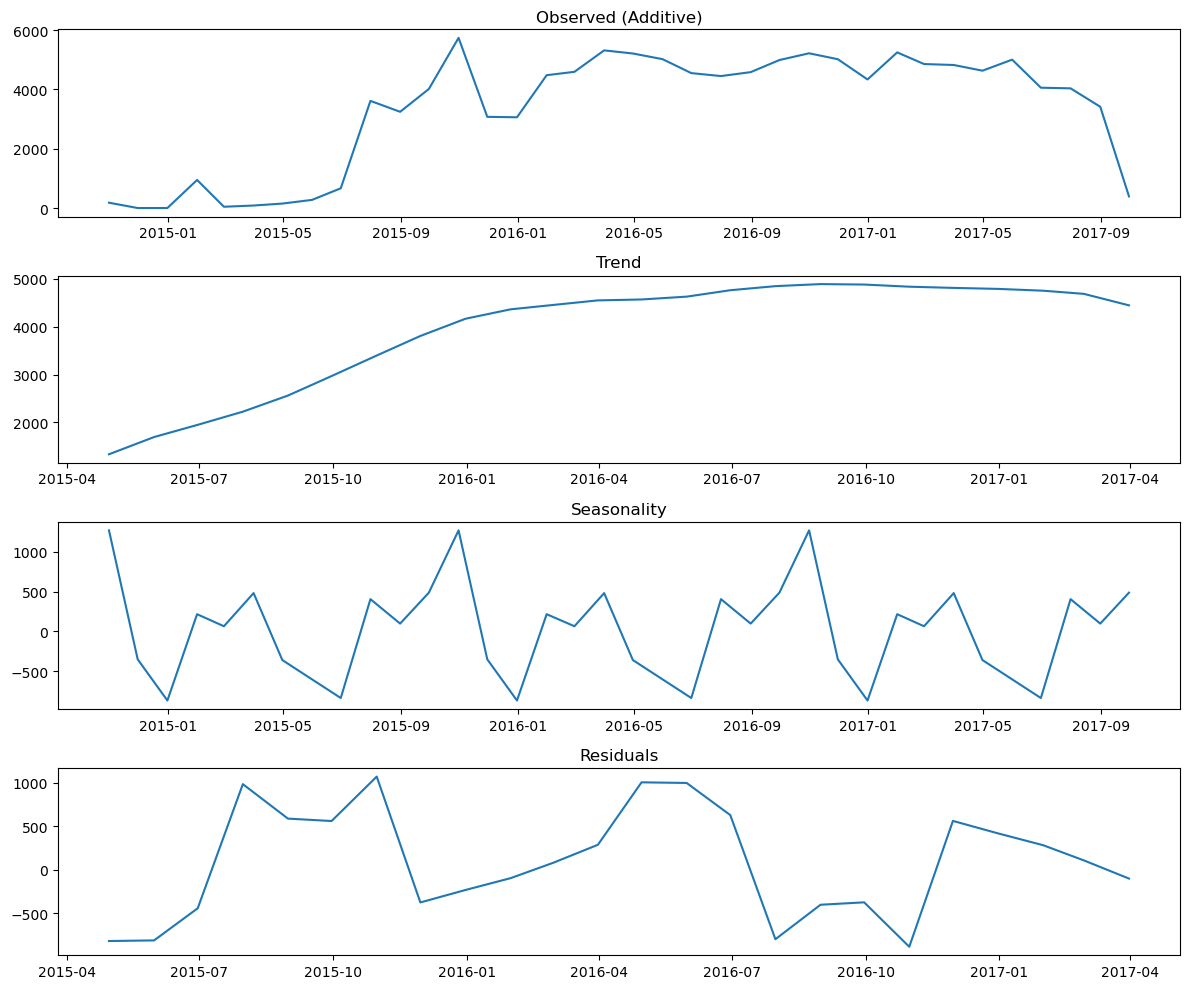

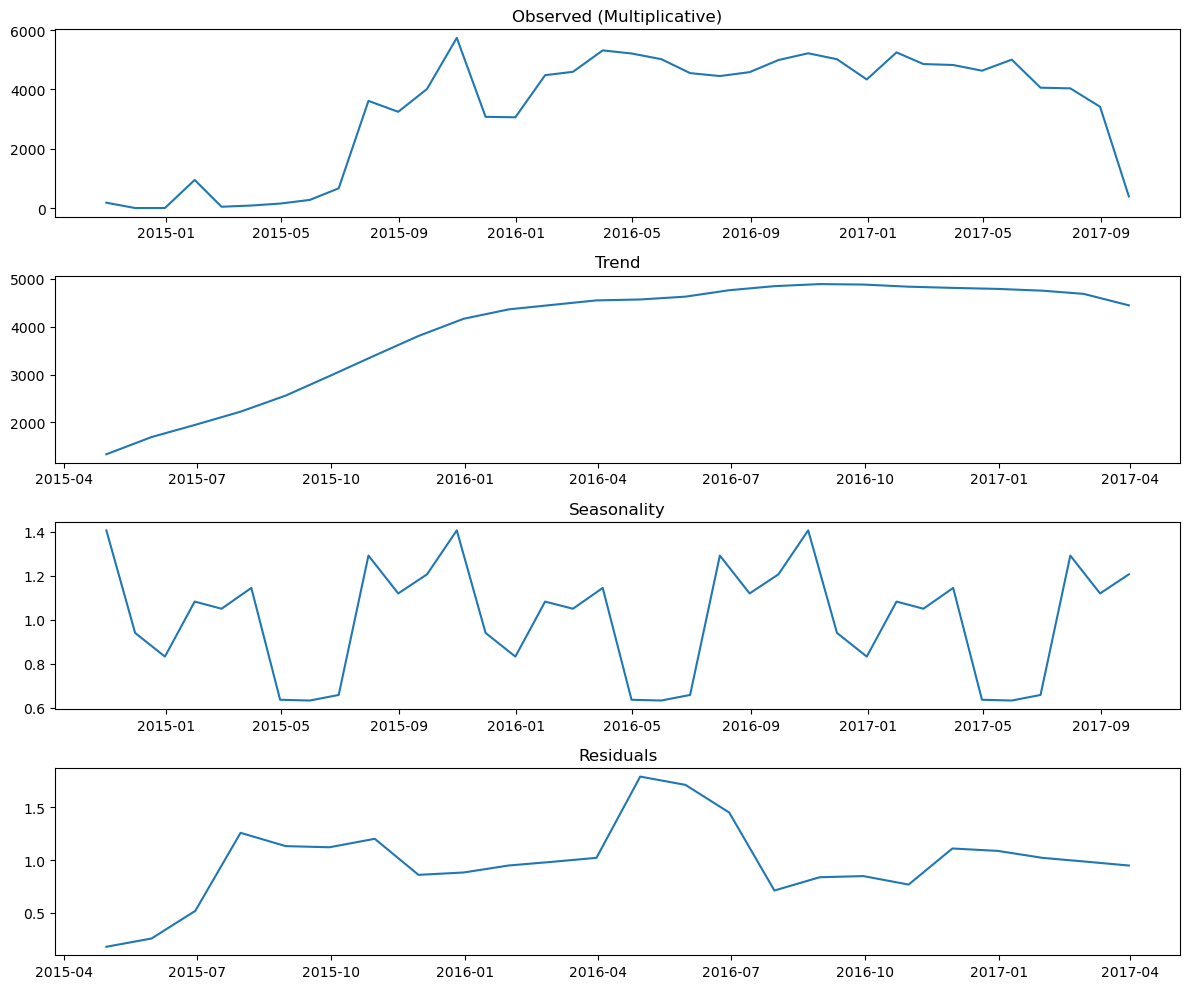

In [14]:
# Resample to monthly data for clearer visualization of patterns
monthly_bookings = daily_bookings.resample('M').sum()

# If any bookings are zero or negative, adjust them to a small positive value
# This is to avoid errors in the multiplicative decomposition
monthly_bookings['bookings'] = monthly_bookings['bookings'].clip(lower=1)  # Or any other suitable small positive value

# Additive decomposition
additive_decomposition = seasonal_decompose(monthly_bookings, model='additive', period=12)

# Multiplicative decomposition
multiplicative_decomposition = seasonal_decompose(monthly_bookings, model='multiplicative', period=12)

# Plot additive decomposition
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(additive_decomposition.observed)
plt.title('Observed (Additive)')
plt.subplot(412)
plt.plot(additive_decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(additive_decomposition.seasonal)
plt.title('Seasonality')
plt.subplot(414)
plt.plot(additive_decomposition.resid)
plt.title('Residuals')
plt.tight_layout()
plt.show()

# Plot multiplicative decomposition
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(multiplicative_decomposition.observed)
plt.title('Observed (Multiplicative)')
plt.subplot(412)
plt.plot(multiplicative_decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(multiplicative_decomposition.seasonal)
plt.title('Seasonality')
plt.subplot(414)
plt.plot(multiplicative_decomposition.resid)
plt.title('Residuals')
plt.tight_layout()
plt.show()


# **3. Forecasting Models & Performance Evaluation**

In [21]:
# Prepare data for forecasting
# Use monthly data for simplicity
ts_data = monthly_bookings.copy()

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

print(f"Training data: {train_data.shape}")
print(f"Testing data: {test_data.shape}")

# Function to calculate metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

Training data: (28, 1)
Testing data: (8, 1)


In [22]:
# 1. ARIMA Model
def fit_arima(train_data, test_data, order=(1,1,1)):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test_data))

    # Calculate metrics
    metrics = calculate_metrics(test_data['bookings'], forecast)

    return forecast, metrics, model_fit


In [23]:
# 2. Exponential Smoothing (ETS)
def fit_ets(train_data, test_data, seasonal_periods=12):
    model = ExponentialSmoothing(
        train_data,
        trend='add',
        seasonal='add',
        seasonal_periods=seasonal_periods
    )
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test_data))

    # Calculate metrics
    metrics = calculate_metrics(test_data['bookings'], forecast)

    return forecast, metrics, model_fit


In [24]:
# 3. Prophet Model
def fit_prophet(train_data, test_data):
    # Prepare data for Prophet
    prophet_train = train_data.reset_index()
    prophet_train.columns = ['ds', 'y']

    # Initialize and fit the model
    model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(prophet_train)

    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test_data), freq='M')
    forecast = model.predict(future)

    # Extract forecasted values for test period
    forecast_test = forecast.tail(len(test_data))

    # Calculate metrics
    metrics = calculate_metrics(test_data['bookings'].values, forecast_test['yhat'].values)

    return forecast_test['yhat'].values, metrics, model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26zzi47a/0_gxjb0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp26zzi47a/egm4w83i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50621', 'data', 'file=/tmp/tmp26zzi47a/0_gxjb0s.json', 'init=/tmp/tmp26zzi47a/egm4w83i.json', 'output', 'file=/tmp/tmp26zzi47a/prophet_modell1a_tln8/prophet_model-20250418160630.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:06:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:06:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA Metrics:
MSE: 2956509.819165827
RMSE: 1719.4504410322
MAE: 1104.439356073776
MAPE: 151.58871341051184

ETS Metrics:
MSE: 8619547.298389023
RMSE: 2935.906554778102
MAE: 1938.2773662270806
MAPE: 249.42683558385758

Prophet Metrics:
MSE: 396976506.7766853
RMSE: 19924.269290909648
MAE: 17754.844526307577
MAPE: 617.560137686753


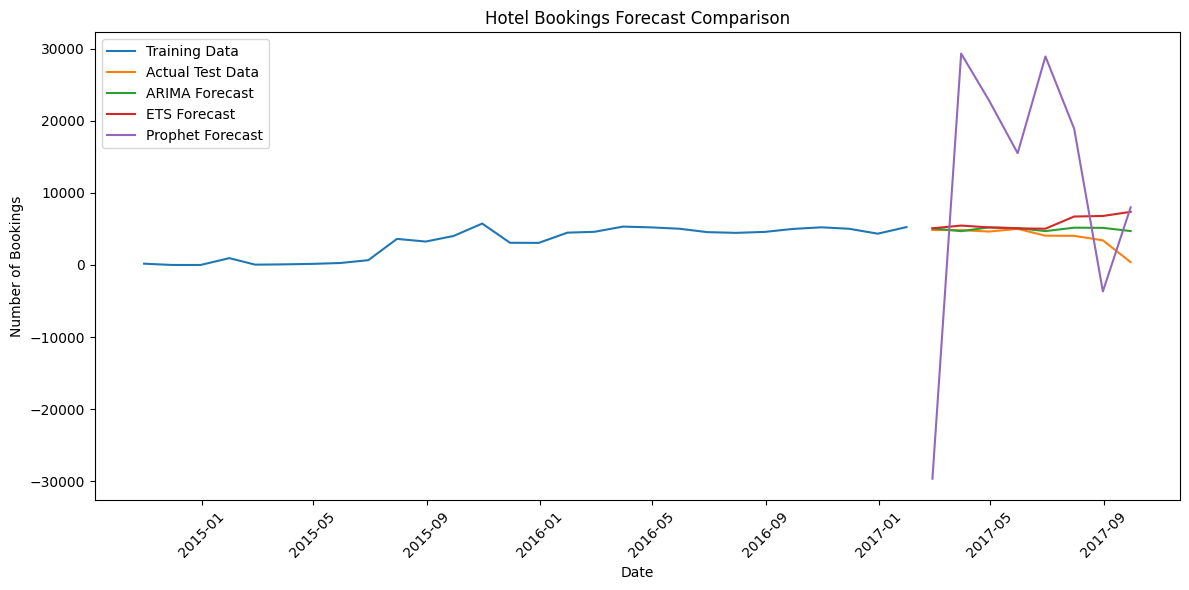

In [11]:
# Fit the models
arima_forecast, arima_metrics, arima_model = fit_arima(train_data, test_data, order=(2,1,2))
ets_forecast, ets_metrics, ets_model = fit_ets(train_data, test_data)
prophet_forecast, prophet_metrics, prophet_model = fit_prophet(train_data, test_data)

# Print metrics
print("ARIMA Metrics:")
for metric, value in arima_metrics.items():
    print(f"{metric}: {value}")

print("\nETS Metrics:")
for metric, value in ets_metrics.items():
    print(f"{metric}: {value}")

print("\nProphet Metrics:")
for metric, value in prophet_metrics.items():
    print(f"{metric}: {value}")

# Visualize forecasts
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['bookings'], label='Training Data')
plt.plot(test_data.index, test_data['bookings'], label='Actual Test Data')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test_data.index, ets_forecast, label='ETS Forecast')
plt.plot(test_data.index, prophet_forecast, label='Prophet Forecast')
plt.title('Hotel Bookings Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **4. Streamlit Web App Implementation**

In [25]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

st.title('Time Series Analysis and Forecasting')

# File upload
uploaded_file = st.file_uploader("Upload a CSV file", type="csv")

if uploaded_file is not None:
    # Load data
    df = pd.read_csv(uploaded_file)

    # Display raw data
    st.subheader('Raw Data')
    st.write(df.head())

    # Date column selection
    st.subheader('Select Date Column')
    date_column = st.selectbox('Choose the date column', df.columns)

    # Value column selection
    st.subheader('Select Value Column')
    if len(df.columns) > 1:
        value_column = st.selectbox('Choose the value column', [col for col in df.columns if col != date_column])
    else:
        st.error('The CSV file should have at least two columns: date and value')
        st.stop()

    # Convert date column to datetime
    try:
        df[date_column] = pd.to_datetime(df[date_column])
    except:
        st.error('Could not convert the selected column to datetime. Please choose a valid date column.')
        st.stop()

    # Create time series
    ts_data = df[[date_column, value_column]].copy()
    ts_data = ts_data.set_index(date_column)
    ts_data = ts_data.sort_index()

    # Resample options
    st.subheader('Resample Time Series')
    resample_options = ['None', 'Daily', 'Weekly', 'Monthly']
    resample_choice = st.selectbox('Choose resampling frequency', resample_options)

    if resample_choice != 'None':
        if resample_choice == 'Daily':
            ts_data = ts_data.resample('D').sum()
        elif resample_choice == 'Weekly':
            ts_data = ts_data.resample('W').sum()
        elif resample_choice == 'Monthly':
            ts_data = ts_data.resample('M').sum()

    # Display time series
    st.subheader('Time Series Data')
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ts_data.index, ts_data[value_column])
    ax.set_title('Time Series Plot')
    ax.set_xlabel('Date')
    ax.set_ylabel(value_column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    st.pyplot(fig)


2025-04-18 14:13:36.422 
  command:

    streamlit run C:\Users\User\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [30]:
st.subheader('Time Series Decomposition')
decomposition_type = st.selectbox('Choose decomposition type', ['Additive', 'Multiplicative'])

# Period selection
min_period = 2
max_period = min(len(ts_data) // 2, 52)  # Limit to half the data length or 52
period = st.slider('Select seasonality period', min_period, max_period, 12)

# Perform decomposition
try:
    if decomposition_type == 'Additive':
        decomposition = seasonal_decompose(ts_data, model='additive', period=period)
    else:
        decomposition = seasonal_decompose(ts_data, model='multiplicative', period=period)

    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

    ax1.plot(decomposition.observed)
    ax1.set_title('Observed')

    ax2.plot(decomposition.trend)
    ax2.set_title('Trend')

    ax3.plot(decomposition.seasonal)
    ax3.set_title('Seasonality')

    ax4.plot(decomposition.resid)
    ax4.set_title('Residuals')

    plt.tight_layout()
    st.pyplot(fig)
except:
    st.error(f"Could not perform decomposition. Try a different period (current: {period}).")

# Forecasting
st.subheader('Time Series Forecasting')

# Get the column name from ts_data
if isinstance(ts_data, pd.DataFrame):
    value_column = ts_data.columns[0]  # Use the first column as the value column
else:
    # If ts_data is a Series, use its name or set a default name
    value_column = ts_data.name if ts_data.name is not None else 'Value'

# Train-test split
st.write('Select training data percentage:')
train_size = st.slider('Training data %', 50, 90, 80)
train_size = int(len(ts_data) * train_size / 100)

train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

st.write(f'Training data: {train_data.shape[0]} records')
st.write(f'Testing data: {test_data.shape[0]} records')

# Model selection
model_choice = st.selectbox('Choose a forecasting model', ['ARIMA', 'ETS', 'Prophet'])

# Function to calculate metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    # Avoid division by zero in MAPE
    mape = np.mean(np.abs((actual - predicted) / np.maximum(actual, 1e-10))) * 100

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

# Initialize forecast variable
forecast = None

# Fit selected model
if model_choice == 'ARIMA':
    st.write('ARIMA Parameters:')
    p = st.slider('p (AR order)', 0, 5, 1)
    d = st.slider('d (Differencing)', 0, 2, 1)
    q = st.slider('q (MA order)', 0, 5, 1)

    with st.spinner('Fitting ARIMA model...'):
        try:
            model = ARIMA(train_data, order=(p, d, q))
            model_fit = model.fit()

            # Forecast
            forecast = model_fit.forecast(steps=len(test_data))

            # Calculate metrics
            if isinstance(test_data, pd.DataFrame):
                metrics = calculate_metrics(test_data[value_column].values, forecast)
            else:
                metrics = calculate_metrics(test_data.values, forecast)
        except Exception as e:
            st.error(f'Error fitting ARIMA model: {e}. Try different parameters.')
            st.stop()

elif model_choice == 'ETS':
    st.write('ETS Parameters:')
    trend_type = st.selectbox('Trend type', ['add', 'mul', None])
    seasonal_type = st.selectbox('Seasonal type', ['add', 'mul', None])

    with st.spinner('Fitting ETS model...'):
        try:
            model = ExponentialSmoothing(
                train_data,
                trend=trend_type,
                seasonal=seasonal_type,
                seasonal_periods=period if seasonal_type is not None else None
            )
            model_fit = model.fit()

            # Forecast
            forecast = model_fit.forecast(steps=len(test_data))

            # Calculate metrics
            if isinstance(test_data, pd.DataFrame):
                metrics = calculate_metrics(test_data[value_column].values, forecast)
            else:
                metrics = calculate_metrics(test_data.values, forecast)
        except Exception as e:
            st.error(f'Error fitting ETS model: {e}. Try different parameters.')
            st.stop()

elif model_choice == 'Prophet':
    with st.spinner('Fitting Prophet model...'):
        try:
            # Determine the frequency
            if 'resample_choice' not in locals():
                # Default to daily if not specified
                resample_choice = 'Daily'

            if resample_choice == 'Daily':
                freq = 'D'
            elif resample_choice == 'Weekly':
                freq = 'W'
            else:
                freq = 'M'

            # Prepare data for Prophet
            prophet_train = train_data.reset_index()
            if isinstance(prophet_train, pd.DataFrame) and len(prophet_train.columns) >= 2:
                prophet_train.columns = ['ds', 'y'] + list(prophet_train.columns[2:])
            else:
                # If it's a Series or has only one column
                prophet_train = pd.DataFrame({
                    'ds': prophet_train.index if hasattr(prophet_train, 'index') else pd.date_range(start='2020-01-01', periods=len(prophet_train)),
                    'y': prophet_train.values.flatten() if hasattr(prophet_train, 'values') else prophet_train
                })

            # Initialize and fit the model
            model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
            model.fit(prophet_train)

            # Create future dataframe for predictions
            future = model.make_future_dataframe(periods=len(test_data), freq=freq)
            forecast_df = model.predict(future)

            # Extract forecasted values for test period
            forecast = forecast_df.tail(len(test_data))['yhat'].values

            # Calculate metrics
            if isinstance(test_data, pd.DataFrame):
                metrics = calculate_metrics(test_data[value_column].values, forecast)
            else:
                metrics = calculate_metrics(test_data.values, forecast)

            # Plot Prophet components
            st.subheader('Prophet Components')
            fig_comp = model.plot_components(forecast_df)
            st.pyplot(fig_comp)

        except Exception as e:
            st.error(f'Error fitting Prophet model: {e}')
            st.stop()

# Initialize metrics to an empty dictionary if not defined
if 'metrics' not in locals():
    metrics = {}

# Display metrics
st.subheader('Forecast Metrics')
# Check if metrics dictionary is not empty before creating DataFrame
if metrics:
    metrics_df = pd.DataFrame({
        'Metric': list(metrics.keys()),
        'Value': list(metrics.values())
    })
    st.table(metrics_df)
else:
    st.warning("No metrics available. Please ensure a model has been successfully fitted.")

# Plot forecast if available
if forecast is not None:
    st.subheader('Forecast Results')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training data
    if isinstance(train_data, pd.DataFrame):
        ax.plot(train_data.index, train_data[value_column], label='Training Data')
    else:
        ax.plot(train_data.index, train_data, label='Training Data')

    # Plot test data
    if isinstance(test_data, pd.DataFrame):
        ax.plot(test_data.index, test_data[value_column], label='Actual Test Data')
    else:
        ax.plot(test_data.index, test_data, label='Actual Test Data')

    # Plot forecast
    ax.plot(test_data.index, forecast, label=f'{model_choice} Forecast', color='red')
    ax.set_title(f'{model_choice} Forecast Results')
    ax.set_xlabel('Date')
    ax.set_ylabel(value_column)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    st.pyplot(fig)

    # Future forecast
    st.subheader('Future Forecast')
    forecast_periods = st.slider('Number of periods to forecast', 1, 24, 12)

    with st.spinner('Generating future forecast...'):
        try:
            # Determine the frequency if not already defined
            if 'resample_choice' not in locals():
                # Default to monthly if not specified
                resample_choice = 'Monthly'

            if model_choice == 'ARIMA':
                future_forecast = model_fit.forecast(steps=forecast_periods)
                future_index = pd.date_range(
                    start=test_data.index[-1] + pd.Timedelta(days=1),
                    periods=forecast_periods,
                    freq='M' if resample_choice == 'Monthly' else ('W' if resample_choice == 'Weekly' else 'D')
                )

            elif model_choice == 'ETS':
                future_forecast = model_fit.forecast(steps=forecast_periods)
                future_index = pd.date_range(
                    start=test_data.index[-1] + pd.Timedelta(days=1),
                    periods=forecast_periods,
                    freq='M' if resample_choice == 'Monthly' else ('W' if resample_choice == 'Weekly' else 'D')
                )

            elif model_choice == 'Prophet':
                future_prophet = model.make_future_dataframe(periods=forecast_periods + len(test_data), freq=freq)
                future_forecast_df = model.predict(future_prophet)
                future_forecast = future_forecast_df.tail(forecast_periods)['yhat'].values
                future_index = future_forecast_df.tail(forecast_periods)['ds'].values

            # Plot future forecast
            fig, ax = plt.subplots(figsize=(10, 6))

            # Plot historical data
            if isinstance(ts_data, pd.DataFrame):
                ax.plot(ts_data.index, ts_data[value_column], label='Historical Data')
            else:
                ax.plot(ts_data.index, ts_data, label='Historical Data')

            ax.plot(future_index, future_forecast, label='Future Forecast', color='red')
            ax.set_title('Future Forecast')
            ax.set_xlabel('Date')
            ax.set_ylabel(value_column)
            ax.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            st.pyplot(fig)

        except Exception as e:
            st.error(f'Error generating future forecast: {e}')
else:
    st.warning("No forecast available. Please ensure a model has been successfully fitted.")

# Check if data exists
if 'ts_data' not in locals():
    st.info('Please upload a CSV file and select date and value columns to begin analysis.')

2025-04-18 17:18:12.907 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 17:18:12.908 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 17:18:12.910 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 17:18:12.911 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 17:18:12.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 17:18:12.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 17:18:12.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 17:18:12.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar